##  A neural Network replacing the simple xgboost regression algorithm

#### Importing all libraries and setting the device to gpu

In [15]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from torch.utils.data import Dataset, DataLoader
import seaborn as sns

# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

#### Pre processing the data and adding data indicators to the data

In [16]:

df = pd.read_csv("../data/titan/titan.csv")
# Need to reverse the db
# df = df.loc[::-1]
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 2020)].copy()
df.index = range(len(df))
temp = df
# df['Close'] = (df['High'] + df['Low'] )/ 2
df.rename(columns={"Open Price":"Open","High Price":"High","Low Price":"Low","Close Price":"Close","Total Traded Quantity":"Volume","No.of Shares":"Volume"},inplace=True)
# cols = ["Symbol","Ser verbose=Falseies","Prev Close","Last Price","Average Price","Turnover","No. of Trades", "Deliverable Qty",'% Dly Qt to Traded Qty']
# cols = ["WAP","No. of Trades"	,"Total Turnover (Rs.)"	,"Deliverable Quantity"	,"% Deli. Qty to Traded Qty"	,"Spread High-Low"	,"Spread Close-Open"]
cols = "Adj Close"
df.drop(columns=cols,inplace=True)   
df.dropna(inplace=True)
df.head()

,Date,Open,High,Low,Close,Volume
0,2020-01-17,1194.800049,1196.849976,1184.000000,1188.750000,1034774
1,2020-01-20,1190.000000,1195.000000,1179.099976,1187.849976,1139858
2,2020-01-21,1183.449951,1183.900024,1161.000000,1176.199951,925998
3,2020-01-22,1181.800049,1185.949951,1172.000000,1177.650024,902471
4,2020-01-23,1176.000000,1206.650024,1175.000000,1204.099976,2101116


In [17]:
df['EMA_9'] = df['Close'].ewm(9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0    
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

df['Close'] = df['Close'].shift(-1)

df = df.iloc[33:] # Because of moving average
df = df[:-1]      # Because of shifting close price

df.index = range(len(df))

df.head()

,Date,Open,High,Low,Close,Volume,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,2020-03-05,1253.500000,1265.150024,1242.199951,1242.599976,1555538,1264.829261,1254.900000,1272.204993,1280.643327,1252.849996,40.111726,1.339990,5.788707
1,2020-03-06,1229.000000,1246.949951,1219.699951,1203.449951,1678642,1264.245090,1251.150000,1265.159997,1279.986662,1255.566663,37.826210,-0.353649,4.412463
2,2020-03-09,1225.000000,1241.849976,1175.000000,1187.650024,2285787,1262.025006,1248.769995,1257.134998,1276.286662,1256.849996,25.022177,-4.618469,2.436546
3,2020-03-11,1197.949951,1213.349976,1177.550049,1076.750000,2314388,1256.032499,1240.629980,1249.489990,1270.286662,1256.036662,23.883133,-9.095396,-0.040031
4,2020-03-12,1150.000000,1153.949951,1064.650024,1084.349976,3608906,1249.052733,1228.759985,1242.244995,1261.726660,1255.164994,11.508613,-20.904596,-4.455698


In [18]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High']
df.drop(columns=drop_cols,inplace=True)
df.head()

,Close,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal
0,1242.599976,1264.829261,1254.900000,1272.204993,1280.643327,1252.849996,40.111726,1.339990,5.788707
1,1203.449951,1264.245090,1251.150000,1265.159997,1279.986662,1255.566663,37.826210,-0.353649,4.412463
2,1187.650024,1262.025006,1248.769995,1257.134998,1276.286662,1256.849996,25.022177,-4.618469,2.436546
3,1076.750000,1256.032499,1240.629980,1249.489990,1270.286662,1256.036662,23.883133,-9.095396,-0.040031
4,1084.349976,1249.052733,1228.759985,1242.244995,1261.726660,1255.164994,11.508613,-20.904596,-4.455698


#### Separating the data into train and test splits. Then splitting into validation split

In [19]:
X = df.iloc[:, 1:]
y = df.iloc[:, 1]

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.2
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.2
)

#### Normalising the data

In [20]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

#### Initialising the dataset

In [21]:
class RegressionDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]

    def __len__(self):
        return len(self.X_data)   

In [22]:
train_dataset = RegressionDataset(
    torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float()
)
val_dataset = RegressionDataset(
    torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float()
)
test_dataset = RegressionDataset(
    torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()
)

#### Setting hyper parameters

In [23]:
EPOCHS = 600
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)

In [24]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE)

In [25]:
class MultipleRegression(nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()

        self.layer_1 = nn.Linear(num_features, 16)
        self.layer_2 = nn.Linear(16, 32)
        self.layer_3 = nn.Linear(32, 16)
        self.layer_out = nn.Linear(16, 1)

        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return x
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

In [26]:
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=8, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


In [27]:
import random

def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU
    
set_seeds()

In [28]:
loss_stats = {
    'train': [],
    "val": []
}

In [29]:
for e in (range(1, EPOCHS + 1)):
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(
            device
        )
        optimizer.zero_grad()

        y_train_pred = model(X_train_batch)

        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))

        train_loss.backward()
        optimizer.step()

        train_epoch_loss += train_loss.item()

    # VALIDATION
    with torch.no_grad():
        val_epoch_loss = 0

        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)

            y_val_pred = model(X_val_batch)

            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))

            val_epoch_loss += val_loss.item()
    # print(torch.cuda.get_device_name())

        loss_stats["train"].append(train_epoch_loss / len(train_loader))
        loss_stats["val"].append(val_epoch_loss / len(val_loader))

    print(
        f"Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}"
    )
# torch.cuda.set_device("cuda:0")
# print(torch.cuda.get_device_name())

Epoch 001: | Train Loss: 4244614.57500 | Val Loss: 4868516.37500
Epoch 002: | Train Loss: 4271084.80000 | Val Loss: 4868192.00000
Epoch 003: | Train Loss: 4280751.82500 | Val Loss: 4867869.50000
Epoch 004: | Train Loss: 4251486.10000 | Val Loss: 4867527.62500
Epoch 005: | Train Loss: 4269342.05000 | Val Loss: 4867100.12500
Epoch 006: | Train Loss: 4225130.30000 | Val Loss: 4866512.12500
Epoch 007: | Train Loss: 4244520.57500 | Val Loss: 4865634.87500
Epoch 008: | Train Loss: 4240284.52500 | Val Loss: 4864204.37500
Epoch 009: | Train Loss: 4234848.60000 | Val Loss: 4861870.00000
Epoch 010: | Train Loss: 4276132.30000 | Val Loss: 4858185.50000
Epoch 011: | Train Loss: 4248074.17500 | Val Loss: 4852376.50000
Epoch 012: | Train Loss: 4253027.40000 | Val Loss: 4843662.75000
Epoch 013: | Train Loss: 4225124.05000 | Val Loss: 4830750.62500
Epoch 014: | Train Loss: 4205006.92500 | Val Loss: 4812053.25000
Epoch 015: | Train Loss: 4189613.67500 | Val Loss: 4785167.50000
Epoch 016: | Train Loss: 

In [30]:
print(len(loss_stats['train']))
print(len(loss_stats['val']))

600
600


Text(0.5, 1.0, 'Train-Val Loss/Epoch')

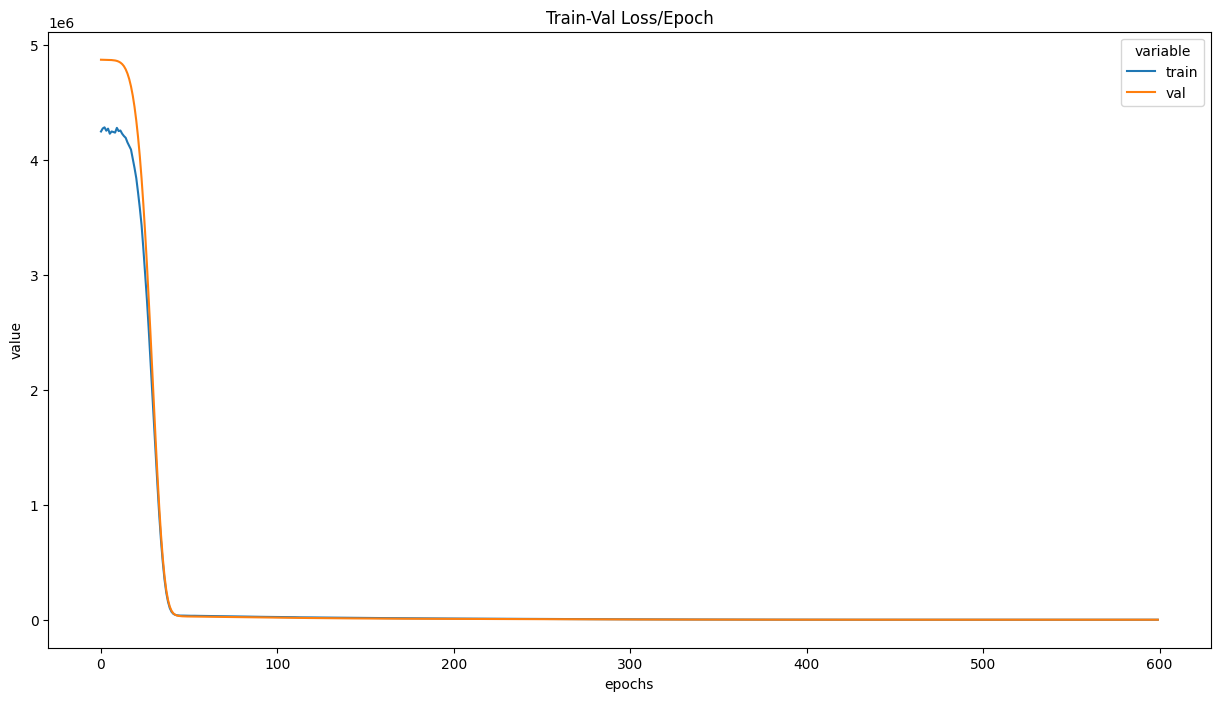

In [31]:
train_val_loss_df = (
    pd.DataFrame.from_dict(loss_stats)
    .reset_index()
    .melt(id_vars=["index"])
    .rename(columns={"index": "epochs"})
)
plt.figure(figsize=(15, 8))
sns.lineplot(data=train_val_loss_df, x="epochs", y="value", hue="variable").set_title(
    "Train-Val Loss/Epoch"
)

In [40]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
        y_pred_list = [a for a in y_pred_list]
        
y_pred = []
for i in range(len(y_pred_list)):
    for j in range(len(y_pred_list[i])):
        for k in range(len(y_pred_list[i][j])):
            y_pred.append(y_pred_list[i][j][k])

print(y_pred)  
print(y_test.tolist())

[2704.6987, 1726.9397, 1951.8098, 1490.7213, 2436.2937, 1690.3223, 2534.6125, 2504.858, 980.4522, 976.52106, 2908.0413, 1726.7932, 2615.0266, 1176.4006, 2657.0876, 948.99713, 2031.9988, 1004.78516, 1514.4756, 1256.555, 904.59686, 973.713, 2536.7668, 2627.8196, 1717.009, 2063.8176, 2831.185, 1489.4977, 1513.3484, 1122.0851, 2534.0134, 2626.0676, 3004.7175, 2443.844, 1473.5657, 2563.2896, 2371.884, 1480.4805, 2072.4202, 2046.5784, 2471.9832, 2459.07, 2457.4626, 2424.8274, 2705.484, 2635.8438, 2630.2622, 2370.3987, 1159.5735, 2346.91, 2509.4907, 1195.4927, 1150.4863, 2453.0613, 1460.5933, 1068.4286, 2951.6292, 1521.0537, 1509.5936, 2478.274, 2341.2812, 2184.8923, 1751.7183, 2642.6401, 881.50604, 2631.8562, 2379.2625, 2562.5269, 2840.2363, 2513.694, 2511.716, 1102.4221, 2449.5432, 999.02716, 2530.8098, 1504.7686, 2329.0479, 977.3802, 1659.5421, 2510.7795, 2378.716, 1470.5161, 1711.1665, 1502.7764, 1490.065, 1511.6726, 1216.9338, 1206.0824, 2552.306, 1126.7754, 964.30756, 3028.5427, 2271.84

In [33]:
mse = mean_squared_error(y_test, y_pred)
r_square = r2_score(y_test, y_pred)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 6.420429770007359
R^2 : 0.9999846059309591


#### Visualising the data

In [34]:
import plotly as py
import plotly.io as pio    
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [42]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=temp.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=temp['Date'],
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple'), row=2, col=1)

fig.add_trace(go.Scatter(x=temp['Date'],
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)


fig.show()